In [1]:
import pandas as pd
import numpy as np

In [2]:
ts_df = pd.read_csv("oil.csv", sep=",")
ts_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [3]:
ts_df.shape

(1218, 2)

def extract_date(x):
    parts = x.split()
    year = parts[0]
    month = parts[1][:2]
    day = parts[1][2:]
    return "%s-%s-%s" % (year, month, day)
ts_df["date"] = ts_df["Unnamed: 0"].apply(extract_date)
ts_df.drop("Unnamed: 0", axis=1, inplace=True)
ts_df.columns = ["value","date"]

In [4]:
ts_df.columns = ["date","value"]

In [5]:
ts_df.drop(0, inplace=True)

In [6]:
ts_df.head()

,date,value
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21


<AxesSubplot:xlabel='date'>

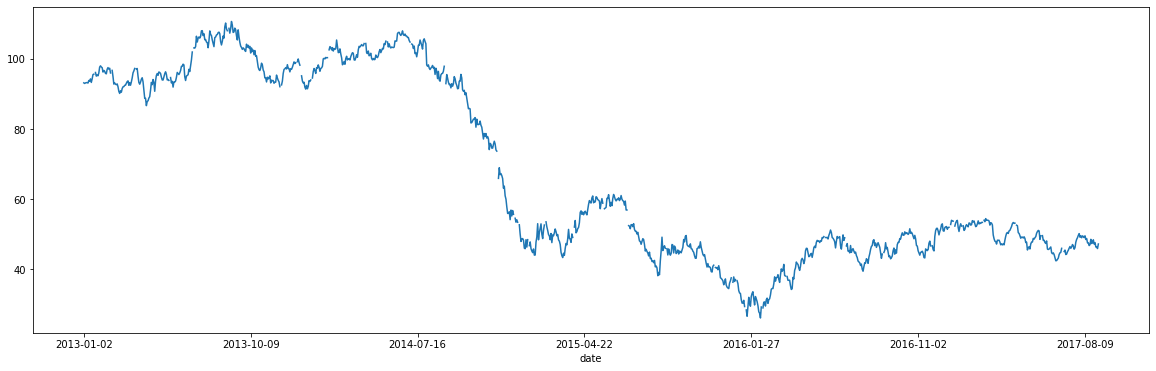

In [7]:
ts_df.set_index("date")["value"].plot(figsize=(20,6))

In [8]:
class TSFeatureCalculator():
    def __init__(self, df, date_col, value_col, shift_by=1, weekday_only=False):
        self.df = df.copy()
        self.date_col = date_col
        self.value_col = value_col
        self.weekday_only = weekday_only
        self.shift_by = shift_by
        self._preprocess()
        
    def _preprocess(self):
        self.df["dt"] = pd.to_datetime(self.df[self.date_col])
        self.df["x"] = self.df[self.value_col].shift(self.shift_by)
        remove_rows = list(self.df.index)[:self.shift_by]
        self.df = self.df.drop(remove_rows)
        self.df["day_of_week"] = self.df["dt"].apply(lambda x: x.dayofweek)
        self.df["month"] = self.df["dt"].apply(lambda x: x.month)
        self.df["day_of_month"] = self.df["dt"].apply(lambda x: x.day)
        self.df = self.df.set_index("dt")
        print(self.df.shape)
        if self.weekday_only:
            print("Excluding weekends!")
            self.df = self.df[self.df["day_of_week"]<5]
            print(self.df.shape)
            
    def generate_window_features(self, window_size=[3,7], window_stats=["mean"], min_periods=None, window_type=None):
        for window in window_size:
            for stat in window_stats:
                if window_type != None:
                    col_name = "%i%s_%s" % (window, window_type, stat)
                    window_setup = "%i%s" % (window, window_type)
                else:
                    col_name = "%i_%s" % (window, stat)
                    window_setup = window
                self.df[col_name] = self.df["x"].rolling(window_setup, min_periods=min_periods).agg(stat)
        print("done")
        
from sklearn.metrics import mean_squared_error
        
def eval_model(y, pred):
    rmse = np.sqrt(mean_squared_error(y, pred))
    mape = np.mean(np.abs(y-pred) / y)
    return [rmse, mape]
        
class TSClassifier():
    def __init__(self, df, target_col, missing_value=None, exclude=None):
        self.df = df.copy()
        self.target_col = target_col
        self.exclude = exclude
        self.missing_value = missing_value
        self._preprocess()
        
    def _preprocess(self):
        if self.exclude != None:
            self.df = self.df.drop(self.exclude, axis=1)
        if self.missing_value != None:
            self.df = self.df.fillna(self.missing_value)
        else:
            self.df = self.df.fillna(method="bfill")
        self.X = self.df.drop(self.target_col, axis=1)
        self.y = list(self.df[self.target_col])
        
    def single_feature_performance(self, part="test", test_ratio=0.3):
        X_tr, y_tr, X_te, y_te = self.temporal_train_test_split(test_ratio)
        features = list(self.X.columns)
        performance = []
        for col in features:
            if part == "test":
                performance.append(eval_model(y_te, X_te[col]))
            elif part == "train":
                performance.append(eval_model(y_tr, X_tr[col]))
            else:
                performance.append(eval_model(self.y, self.X[col]))
        return pd.DataFrame(performance, index=features, columns=["rmse","mape"])
        
    def temporal_train_test_split(self, test_ratio=0.3):
        test_size = int(len(self.df)*test_ratio)
        train_size = len(self.df)-test_size
        X_te = self.X.tail(test_size)
        X_tr = self.X.head(train_size)
        y_te = self.y[-test_size:]
        y_tr = self.y[:train_size]
        return X_tr, y_tr, X_te, y_te
    
    def get_feature_importance(self, importances, exclude_zero=False):
        pairs = list(zip(self.X.columns, importances))
        importance_df = pd.DataFrame(pairs, columns=["name","value"]).sort_values("value")
        if exclude_zero:
            importance_df = importance_df[np.abs(importance_df["value"])>0]
        return importance_df

In [9]:
#predict for next week value
sizes = [3,7,14,30,60,90]
#sizes = [3,5,10,20,40,60]
stats = ["mean","std"]
tsf = TSFeatureCalculator(ts_df, "date", "value", 5, True)
tsf.generate_window_features(window_size=sizes, window_stats=stats, min_periods=1)#, window_type="D")

(1212, 6)
Excluding weekends!
(1212, 6)
done


In [10]:
tsf.df.head(10)

,date,value,x,day_of_week,month,day_of_month,3_mean,3_std,7_mean,7_std,14_mean,14_std,30_mean,30_std,60_mean,60_std,90_mean,90_std
dt,,,,,,,,,,,,,,,,,,
2013-01-09,2013-01-09,93.08,93.14,2,1,9,93.140000,NaN,93.140000,NaN,93.140000,NaN,93.140000,NaN,93.140000,NaN,93.140000,NaN
2013-01-10,2013-01-10,93.81,92.97,3,1,10,93.055000,0.120208,93.055000,0.120208,93.055000,0.120208,93.055000,0.120208,93.055000,0.120208,93.055000,0.120208
2013-01-11,2013-01-11,93.60,93.12,4,1,11,93.076667,0.092916,93.076667,0.092916,93.076667,0.092916,93.076667,0.092916,93.076667,0.092916,93.076667,0.092916
2013-01-14,2013-01-14,94.27,93.20,0,1,14,93.096667,0.116762,93.107500,0.097767,93.107500,0.097767,93.107500,0.097767,93.107500,0.097767,93.107500,0.097767
2013-01-15,2013-01-15,93.26,93.21,1,1,15,93.176667,0.049329,93.128000,0.096281,93.128000,0.096281,93.128000,0.096281,93.128000,0.096281,93.128000,0.096281
2013-01-16,2013-01-16,94.28,93.08,2,1,16,93.163333,0.072342,93.120000,0.088318,93.120000,0.088318,93.120000,0.088318,93.120000,0.088318,93.120000,0.088318
2013-01-17,2013-01-17,95.49,93.81,3,1,17,93.366667,0.389401,93.218571,0.272973,93.218571,0.272973,93.218571,0.272973,93.218571,0.272973,93.218571,0.272973
2013-01-18,2013-01-18,95.61,93.60,4,1,18,93.496667,0.375810,93.284286,0.304459,93.266250,0.286453,93.266250,0.286453,93.266250,0.286453,93.266250,0.286453
2013-01-21,2013-01-21,NaN,94.27,0,1,21,93.893333,0.342685,93.470000,0.444897,93.377778,0.428654,93.377778,0.428654,93.377778,0.428654,93.377778,0.428654


### Why MAPE is wrong?

In [11]:
exclude = ["date","month","day_of_month","day_of_week"]
tsc = TSClassifier(tsf.df, "value", missing_value=None, exclude=exclude)
print(tsc.single_feature_performance().sort_values("rmse"))
X_tr, y_tr, X_te, y_te = tsc.temporal_train_test_split()
print(len(X_tr), len(X_te))

              rmse      mape
x         2.066419  0.034621
3_mean    2.181813  0.036620
7_mean    2.461158  0.042564
14_mean   2.881901  0.050892
30_mean   3.234389  0.056799
60_mean   4.143142  0.070993
90_mean   4.833783  0.079684
90_std   44.871377  0.930681
60_std   45.389804  0.941956
30_std   46.096737  0.956801
14_std   46.734561  0.970019
7_std    47.137294  0.978638
3_std    47.476884  0.985928
849 363


#### For simple task baselines are better...

In [12]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(max_depth=1), GradientBoostingRegressor(n_estimators=30, max_depth=1)]
for model in models:
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    print(eval_model(y_te, y_pred))

[2.09246730040934, 0.03554092136468194]
[2.0840002945375535, 0.034904330993950135]
[2.092225379364084, 0.035536318853978364]
[2.0893316128128196, 0.034893540381795575]
[3.7225508686212905, 0.061777544478312206]
[2.3919792200908443, 0.04051279268873697]


In [13]:
tsc.get_feature_importance(models[1].coef_, True)

,name,value
11,90_mean,-0.013070
1,3_mean,0.065279
0,x,0.944284


In [14]:
tsc.get_feature_importance(models[-1].feature_importances_, True)

,name,value
1,3_mean,0.065572
3,7_mean,0.083501
9,60_mean,0.116304
11,90_mean,0.221032
0,x,0.242120
7,30_mean,0.271471
